### CSV test

In [2]:
import pandas as pd
bird_results = pd.read_csv('logs_merged.csv')
bird_results.head(2)


,Unnamed: 0,question,gold_query,db_id,final_query,schema_linking,classification,sql_generation,self_correction
0,0,What is the highest eligible free rate for K-1...,SELECT `FRPM Count (K-12)` / `Enrollment (K-12...,california_schools,"SELECT frpm.""FRPM Count (K-12)"" / frpm.""Enroll...","""highest eligible free rate"" so we need column...",The SQL query for the given question needs the...,"For creating the SQL for the given question, w...","1) The column `MAX(frpm.""FRPM Count (K-12)"") /..."
1,1,Please list the lowest three eligible free rat...,SELECT `Free Meal Count (Ages 5-17)` / `Enroll...,california_schools,"SELECT frpm.""Free Meal Count (Ages 5-17)"" / fr...","""lowest three eligible free rates"" so we need ...",The SQL query for the given question needs the...,"For creating the SQL for the given question, w...","1) The column ""School Name"" is not mentioned i..."


In [18]:
bird_results.size

12726

### Plots

In [15]:
data ={
    'Name': ['Zero-Shot (GPT-3.5)','Few-Shot (GPT-3.5)','DIN-SQL (GPT-3.5)',"Zero-Shot (GPT-4)"],
    'Iteration 1': [37.14, 36.19, 40.57, 38.09],
    'Iteration 2': [45.28, 50, 50.94, 55.66]
}
df = pd.DataFrame(data)


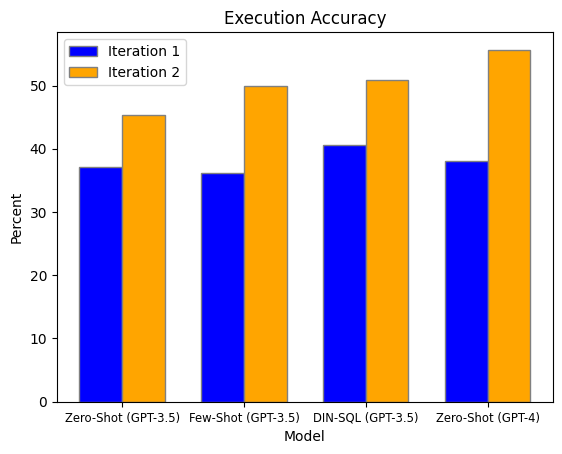

In [16]:
import matplotlib.pyplot as plt
import numpy as np
 
# Set the width of the bars
barWidth = 0.35


# Set position of bar on X axis
r1 = np.arange(len(df['Iteration 1']))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, df['Iteration 1'], color='b', width=barWidth, edgecolor='grey', label='Iteration 1')
plt.bar(r2, df['Iteration 2'], color='orange', width=barWidth, edgecolor='grey', label='Iteration 2')

# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.xticks([r + barWidth/2 for r in range(len(df['Iteration 1']))], df['Name'], fontsize='small')

#y-axis
plt.ylabel('Percent')
# Create legend & Show graphic
plt.legend()
plt.title('Execution Accuracy')
plt.show()
